In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from model import walk_forward_validation
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Using TensorFlow backend.


Load Data

In [2]:
data = pd.read_csv('./vgi2.csv')
data.index = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.pop('date')
data = pd.DataFrame(data, dtype=np.float64)


# train_split = data.index.get_loc('2021-10-29')
# close = data.pop('close')
# data.insert(5, 'close', close)
# data1 = data.iloc[809:, 0]  #3501, 5
# residuals = pd.read_csv('./ARIMA_residuals1.csv')
# residuals.index = pd.to_datetime(residuals['date'])  #trade_date
# residuals.pop('date')
# merge_data = pd.merge(data, residuals, on='date')
# #merge_data = merge_data.drop(labels='2007-01-04', axis=0)
# time = pd.Series(data.index[810:]) # thay vì 809, vị trí đầu tiên sẽ bị remove vì nan value dó đó index bị lùi 1 step


Load ARIMA residuals and merge with close, open, high, low, nmVolume

In [3]:
residuals = pd.read_csv('./ARIMA_residuals1.csv')
residuals.index = pd.to_datetime(residuals['date'])  #trade_date
residuals.pop('date')
merge_data = pd.merge(data, residuals, on='date')

In [6]:
residuals.head()

,0
date,
2018-09-26,2.886284
2018-09-27,3.486284
2018-09-28,0.786284
2018-10-01,-1.413716
2018-10-02,-0.813716


In [4]:
merge_data = merge_data.rename(columns={'0':'Residual'})
merge_data

,close,open,high,low,nmVolume,Residual
date,,,,,,
2018-09-26,23.9,23.9,23.9,23.8,214200.0,2.886284
2018-09-27,27.4,27.4,27.4,27.4,388100.0,3.486284
2018-09-28,28.2,31.5,31.5,27.4,2111074.0,0.786284
2018-10-01,26.8,29.5,29.6,25.8,831097.0,-1.413716
2018-10-02,26.0,27.1,27.3,25.9,596270.0,-0.813716
...,...,...,...,...,...,...
2021-12-27,32.4,31.7,32.8,31.7,289274.0,0.886284
2021-12-28,31.9,32.4,32.8,31.8,235860.0,-0.513716
2021-12-29,31.8,32.0,32.0,31.6,243603.0,-0.113716


Spliting Train - Validation - Test 

In [5]:
train = merge_data[merge_data.index <= '2020-11-24']
valid = merge_data[(merge_data.index <= '2021-10-29')&(merge_data.index > '2020-11-24')]
test_set = merge_data[(merge_data.index <= '2021-12-31')&(merge_data.index > '2021-10-29')]
training_set = pd.concat([train, valid], axis=0)
print('train shape:', train.shape)
print('validation shape:', valid.shape)
print('test shape:', test_set.shape)

train shape: (565, 6)
validation shape: (243, 6)
test shape: (45, 6)


Load the Predictions from ARIMA model on Test set

In [8]:
Lt = pd.read_csv('./ARIMA.csv')
Lt

,date,close
0,2021-11-01,39.022277
1,2021-11-02,38.721879
2,2021-11-03,38.821975
3,2021-11-04,37.520345
4,2021-11-05,37.920813
5,2021-11-08,37.720541
6,2021-11-09,37.720516
7,2021-11-10,37.620368
8,2021-11-11,37.319975
9,2021-11-12,36.619094


In [9]:
Lt = Lt.drop('date', axis=1)
Lt = np.array(Lt)
Lt = Lt.flatten().tolist()

Load the Predictions from ARIMA model on Validation set

In [10]:
Vt = pd.read_csv('./ARIMA_Validation.csv')
Vt

,date,close
0,2020-11-25,32.019469
1,2020-11-26,30.717138
2,2020-11-27,30.717108
3,2020-11-30,31.318134
4,2020-12-01,30.917399
...,...,...
238,2021-10-25,37.520548
239,2021-10-26,36.919776
240,2021-10-27,37.420373
241,2021-10-28,37.520471


In [11]:
Vt = Vt.drop('date', axis=1)
Vt = np.array(Vt)
Vt = Vt.flatten().tolist()

In [12]:
training_set


,close,open,high,low,nmVolume,Residual
date,,,,,,
2018-09-26,23.9,23.9,23.9,23.8,214200.0,2.886284
2018-09-27,27.4,27.4,27.4,27.4,388100.0,3.486284
2018-09-28,28.2,31.5,31.5,27.4,2111074.0,0.786284
2018-10-01,26.8,29.5,29.6,25.8,831097.0,-1.413716
2018-10-02,26.0,27.1,27.3,25.9,596270.0,-0.813716
...,...,...,...,...,...,...
2021-10-25,36.9,37.9,37.9,36.7,533523.0,-0.613716
2021-10-26,37.4,36.9,37.8,36.6,727721.0,0.486284
2021-10-27,37.5,37.4,37.9,37.3,752737.0,0.086284


Convert to supervised data

In [13]:
def prepare_data_valiation(train_series, n_valid, n_in, n_out):
    values = train_series.values
    supervised_data = series_to_supervised(values, n_in, n_out)
    print('supervised_data', supervised_data)
    idx = train_series.shape[0] - n_valid
    train, valid = supervised_data.loc[:idx, :], supervised_data.loc[idx:, :]
    return train, valid, supervised_data

In [14]:
def prepare_data_test(series, n_test, n_in, n_out):
    values = series.values
    supervised_data = series_to_supervised(values, n_in, n_out)
    print('supervised_data', supervised_data)
    idx = series.shape[0] - n_test
    train, test = supervised_data.loc[:idx, :], supervised_data.loc[idx:, :]
    return train, test, supervised_data

#Train and Valid set will be split from Traing_set for Validation process

In [96]:
# from utils import *
n_timestamp = 1

train_supervised, valid_supervised, supervised_data_validation = prepare_data_valiation(training_set, n_valid=valid.shape[0], n_in=n_timestamp, n_out=1)

supervised_data      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1         23.9       23.9       23.9       23.8   214200.0   2.886284   
2         27.4       27.4       27.4       27.4   388100.0   3.486284   
3         28.2       31.5       31.5       27.4  2111074.0   0.786284   
4         26.8       29.5       29.6       25.8   831097.0  -1.413716   
5         26.0       27.1       27.3       25.9   596270.0  -0.813716   
..         ...        ...        ...        ...        ...        ...   
803       37.5       37.8       38.0       37.0   669286.0  -0.313716   
804       36.9       37.9       37.9       36.7   533523.0  -0.613716   
805       37.4       36.9       37.8       36.6   727721.0   0.486284   
806       37.5       37.4       37.9       37.3   752737.0   0.086284   
807       38.1       37.8       38.1       37.6   847445.0   0.586284   

     var1(t)  var2(t)  var3(t)  var4(t)    var5(t)   var6(t)  
1       27.4     27.4     27.4     27.4   38

In [104]:
print(train_supervised.shape)
print(valid_supervised.shape)


(565, 12)
(243, 12)


#Spliting for Testing process

In [105]:
# from utils import *
n_timestamp = 1

training_set_supervised, test_supervised, supervised_data_test = prepare_data_test(merge_data, n_test=test_set.shape[0], n_in=n_timestamp, n_out=1)

supervised_data      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1         23.9       23.9       23.9       23.8   214200.0   2.886284   
2         27.4       27.4       27.4       27.4   388100.0   3.486284   
3         28.2       31.5       31.5       27.4  2111074.0   0.786284   
4         26.8       29.5       29.6       25.8   831097.0  -1.413716   
5         26.0       27.1       27.3       25.9   596270.0  -0.813716   
..         ...        ...        ...        ...        ...        ...   
848       31.5       31.6       32.0       31.2   309880.0  -0.113716   
849       32.4       31.7       32.8       31.7   289274.0   0.886284   
850       31.9       32.4       32.8       31.8   235860.0  -0.513716   
851       31.8       32.0       32.0       31.6   243603.0  -0.113716   
852       31.8       31.6       32.0       31.6   216170.0  -0.013716   

     var1(t)  var2(t)  var3(t)  var4(t)    var5(t)   var6(t)  
1       27.4     27.4     27.4     27.4   38

In [106]:

print(training_set_supervised.shape)
print(test_supervised.shape)

(808, 12)
(45, 12)


In [107]:
merge_data.tail(10)

,close,open,high,low,nmVolume,Residual
date,,,,,,
2021-12-20,32.7,32.8,32.9,32.4,373911.0,0.086284
2021-12-21,32.5,32.6,32.8,32.4,329005.0,-0.213716
2021-12-22,32.3,32.5,32.6,32.0,509289.0,-0.213716
2021-12-23,31.6,32.4,32.5,31.0,562550.0,-0.713716
2021-12-24,31.5,31.6,32.0,31.2,309880.0,-0.113716
2021-12-27,32.4,31.7,32.8,31.7,289274.0,0.886284
2021-12-28,31.9,32.4,32.8,31.8,235860.0,-0.513716
2021-12-29,31.8,32.0,32.0,31.6,243603.0,-0.113716
2021-12-30,31.8,31.6,32.0,31.6,216170.0,-0.013716


In [108]:
supervised_data_test.tail(1).T

,852
var1(t-1),31.800000
var2(t-1),31.600000
var3(t-1),32.000000
var4(t-1),31.600000
var5(t-1),216170.000000
var6(t-1),-0.013716
var1(t),32.700000
var2(t),31.900000
var3(t),33.100000
var4(t),31.900000


In [109]:
training_set_supervised.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
1,23.9,23.9,23.9,23.8,214200.0,2.886284,27.4,27.4,27.4,27.4,388100.0,3.486284
2,27.4,27.4,27.4,27.4,388100.0,3.486284,28.2,31.5,31.5,27.4,2111074.0,0.786284
3,28.2,31.5,31.5,27.4,2111074.0,0.786284,26.8,29.5,29.6,25.8,831097.0,-1.413716
4,26.8,29.5,29.6,25.8,831097.0,-1.413716,26.0,27.1,27.3,25.9,596270.0,-0.813716
5,26.0,27.1,27.3,25.9,596270.0,-0.813716,23.5,26.2,26.2,23.0,705230.0,-2.513716


Min Max Scale

In [97]:
from sklearn.preprocessing import MinMaxScaler

data_sc = MinMaxScaler(feature_range=(0, 1))
train_scaled = data_sc.fit_transform(train_supervised)
valid_scaled = data_sc.transform(valid_supervised)

In [110]:
data_sc2 = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = data_sc2.fit_transform(training_set_supervised)
test_set_scaled = data_sc2.transform(test_supervised)

ERROR! Session/line number was not unique in database. History logging moved to new session 241


In [111]:
train_scaled = pd.DataFrame(train_scaled, columns=train_supervised.columns)
valid_scaled = pd.DataFrame(valid_scaled, columns=valid_supervised.columns)

training_set_scaled = pd.DataFrame(training_set_scaled, columns=training_set_supervised.columns)
test_set_scaled = pd.DataFrame(test_set_scaled, columns=test_supervised.columns)


XGBoost Model with the data supervised from merge_data (close, open, high, low, nmVolume, Residual)

#ARIMA-XGBoost Model: XGBoost will predict the residuals, then plus ARIMA predictions into the final predictions

##Validation Process

In [54]:
time = valid.index
time

DatetimeIndex(['2020-11-25', '2020-11-26', '2020-11-27', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-07', '2020-12-08',
               ...
               '2021-10-18', '2021-10-19', '2021-10-20', '2021-10-21',
               '2021-10-22', '2021-10-25', '2021-10-26', '2021-10-27',
               '2021-10-28', '2021-10-29'],
              dtype='datetime64[ns]', name='date', length=243, freq=None)

1 >expected=0.333333, predicted=0.343335
2 >expected=0.506667, predicted=0.516580
3 >expected=0.586667, predicted=0.489376
4 >expected=0.453333, predicted=0.458865
5 >expected=0.573333, predicted=0.524332
6 >expected=0.680000, predicted=0.739279
7 >expected=0.453333, predicted=0.452594
8 >expected=0.480000, predicted=0.525529
9 >expected=0.560000, predicted=0.361846
10 >expected=0.453333, predicted=0.463835
11 >expected=0.520000, predicted=0.523248
12 >expected=0.573333, predicted=0.583515
13 >expected=0.613333, predicted=0.441931
14 >expected=0.506667, predicted=0.509416
15 >expected=0.426667, predicted=0.391748
16 >expected=0.466667, predicted=0.510616
17 >expected=0.506667, predicted=0.469787
18 >expected=0.546667, predicted=0.515019
19 >expected=0.546667, predicted=0.518101
20 >expected=0.786667, predicted=0.590116
21 >expected=0.333333, predicted=0.448031
22 >expected=0.386667, predicted=0.519600
23 >expected=0.586667, predicted=0.514195
24 >expected=0.466667, predicted=0.487557
2

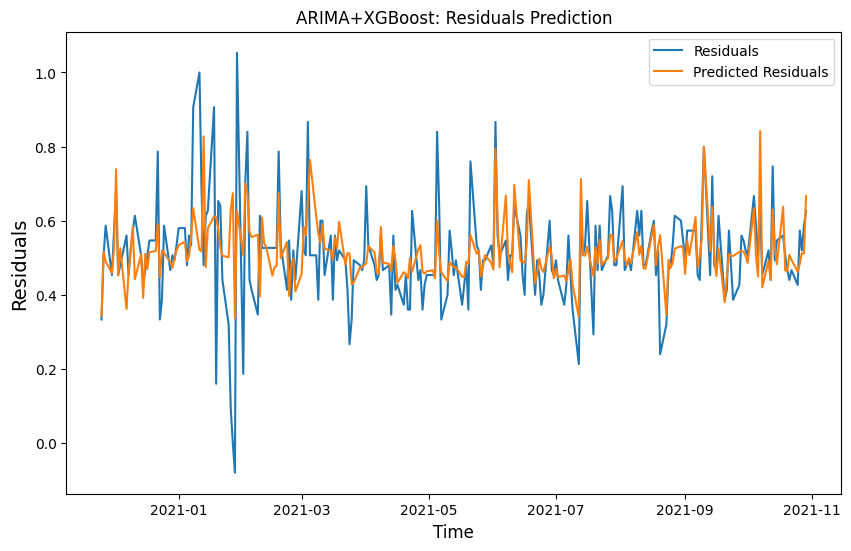

In [112]:
y, yhat = walk_forward_validation(train_scaled, valid_scaled)
plt.figure(figsize=(10, 6))
plt.plot(time, y, label='Residuals')
plt.plot(time, yhat, label='Predicted Residuals')
plt.title('ARIMA+XGBoost: Residuals Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Residuals', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [114]:
train_min = train_supervised.min(axis=0)[5] # 5 means residual position
train_max = train_supervised.max(axis=0)[5]
print(train_min)
print(train_max)

-3.8137162954279016
3.6862837045720984


In [115]:
# Valid set
y_hat_valid_unscaled = np.asarray(yhat)*(train_max - train_min) + train_min
y_valid_unscaled = np.asarray(y)*(train_max - train_min) + train_min

In [116]:
# def evaluation_metric(y_test,y_hat):
evaluation_metric(y_valid_unscaled, y_hat_valid_unscaled )

# def GetMAPE(y_hat, y_test):
GetMAPE(y_hat_valid_unscaled, y_valid_unscaled)



MSE: 0.83281
RMSE: 0.91258
MAE: 0.57455
R2: 0.20700


254.85161714497107

MSE: 0.83644
RMSE: 0.91457
MAE: 0.57544
R2: 0.95696
MAPE_ARIMA-XGBoost_Validation: 1.5858401261736605 %


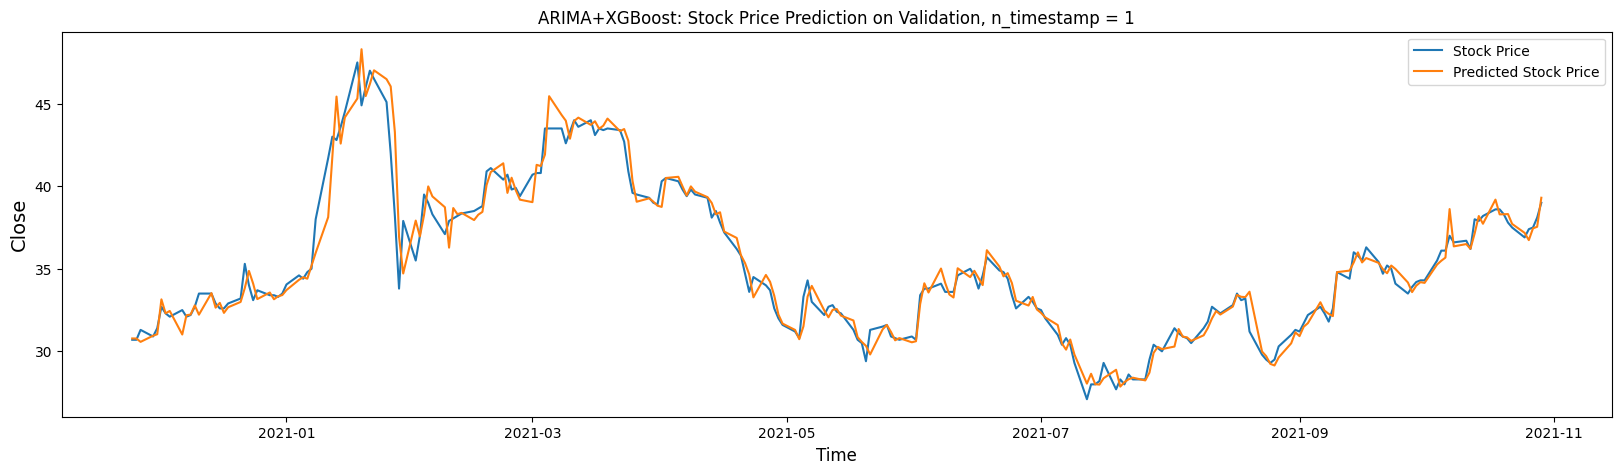

In [119]:
finalpredicted_stock_price = [i + j for i, j in zip(Vt, y_hat_valid_unscaled)]
#print('final', finalpredicted_stock_price)
evaluation_metric(valid.iloc[:,0], finalpredicted_stock_price)

print('MAPE_ARIMA-XGBoost_Validation:', GetMAPE(finalpredicted_stock_price, valid.iloc[:,0]), '%')


plt.figure(figsize=(20, 5))
plt.plot(time, valid.iloc[:,0], label='Stock Price')
plt.plot(time, finalpredicted_stock_price, label='Predicted Stock Price')
plt.title(f'ARIMA+XGBoost: Stock Price Prediction on Validation, n_timestamp = {n_timestamp}')

plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

# n_timestamp = 0
# MSE: 0.92375
# RMSE: 0.96112
# MAE: 0.56679
# R2: 0.95247
# MAPE_ARIMA-XGBoost_Validation: 1.5584695259033352 %

# n_timestamp = 1
# MSE: 0.83644
# RMSE: 0.91457
# MAE: 0.57544
# R2: 0.95696
# MAPE_ARIMA-XGBoost_Validation: 1.5858401261736605 %

# n_timestamp = 6
# MSE: 1.11843
# RMSE: 1.05756
# MAE: 0.65351
# R2: 0.94245
# MAPE_ARIMA-XGBoost_Validation: 1.8010548292247548 %

###Plus XGBoost residual prediction with ARIMA predictions

##Testing Process

1 >expected=0.482353, predicted=0.497594
2 >expected=0.529412, predicted=0.516615
3 >expected=0.364706, predicted=0.486128
4 >expected=0.564706, predicted=0.517984
5 >expected=0.494118, predicted=0.529944
6 >expected=0.517647, predicted=0.500235
7 >expected=0.505882, predicted=0.496815
8 >expected=0.482353, predicted=0.507623
9 >expected=0.435294, predicted=0.501444
10 >expected=0.494118, predicted=0.487040
11 >expected=0.611765, predicted=0.528742
12 >expected=0.458824, predicted=0.483556
13 >expected=0.635294, predicted=0.587048
14 >expected=0.482353, predicted=0.494061
15 >expected=0.388235, predicted=0.442001
16 >expected=0.200000, predicted=0.363413
17 >expected=0.635294, predicted=0.771688
18 >expected=0.517647, predicted=0.503957
19 >expected=0.552941, predicted=0.534107
20 >expected=0.458824, predicted=0.488069
21 >expected=0.458824, predicted=0.509657
22 >expected=0.611765, predicted=0.538763
23 >expected=0.529412, predicted=0.537888
24 >expected=0.529412, predicted=0.507434
2

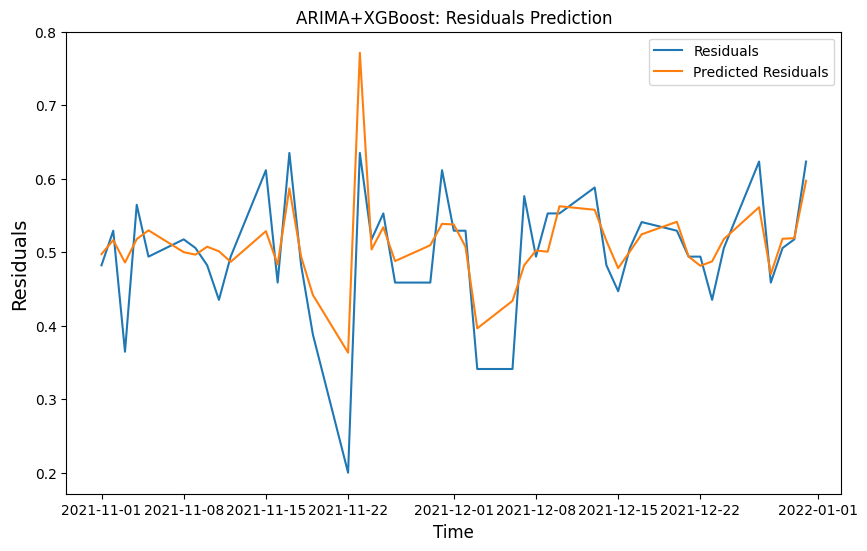

In [120]:
time_test = test_set.index
y_test, yhat_test = walk_forward_validation(training_set_scaled, test_set_scaled)

plt.figure(figsize=(10, 6))
plt.plot(time_test, y_test, label='Residuals')
plt.plot(time_test, yhat_test, label='Predicted Residuals')
plt.title('ARIMA+XGBoost: Residuals Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Residuals', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [121]:
training_set_min = training_set_supervised.min(axis=0)[5] # 5 means residual position
training_set_max = training_set_supervised.max(axis=0)[5]
print(training_set_min)
print(training_set_max)

# Valid set
y_hat_test_unscaled = np.asarray(yhat_test)*(training_set_max - training_set_min) + training_set_min
y_test_unscaled = np.asarray(y_test)*(training_set_max - training_set_min) + training_set_min

-4.413716295427907
4.0862837045721


In [122]:
# def evaluation_metric(y_test,y_hat):
evaluation_metric(y_test_unscaled, y_hat_test_unscaled)

# def GetMAPE(y_hat, y_test):
GetMAPE(y_hat_test_unscaled, y_test_unscaled)

# MSE: 0.36510
# RMSE: 0.60423
# MAE: 0.44403
# R2: 0.27840
# 157.67322619794388

MSE: 0.20358
RMSE: 0.45120
MAE: 0.32605
R2: 0.59762


111.45234111229895

###Plus XGBoost residual prediction with ARIMA predictions

MSE: 0.20460
RMSE: 0.45233
MAE: 0.32653
R2: 0.96108
MAPE_ARIMA-XGBoost_Testing: 0.9469896700985768 %


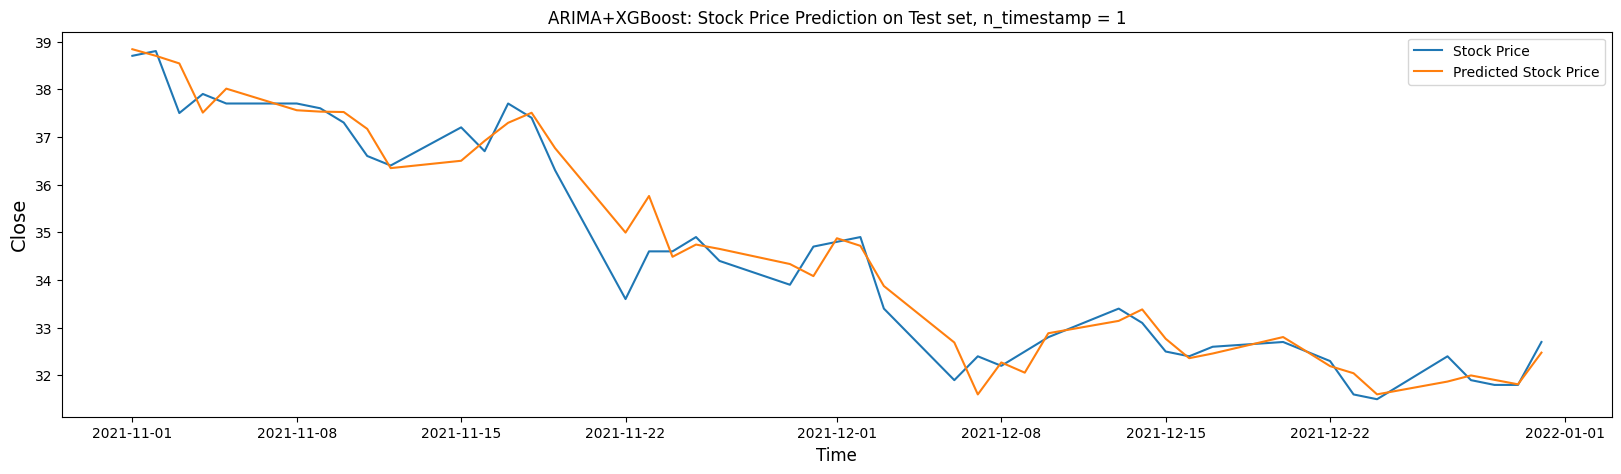

In [123]:

finalpredicted_stock_price2 = [i + j for i, j in zip(Lt, y_hat_test_unscaled)]
#print('final', finalpredicted_stock_price)
evaluation_metric(test_set.iloc[:, 0], finalpredicted_stock_price2)

print('MAPE_ARIMA-XGBoost_Testing:', GetMAPE(finalpredicted_stock_price2, test_set.iloc[:, 0]), '%')


plt.figure(figsize=(20, 5))
plt.plot(time_test, test_set.iloc[:, 0], label='Stock Price')
plt.plot(time_test, finalpredicted_stock_price2, label='Predicted Stock Price')
plt.title(f'ARIMA+XGBoost: Stock Price Prediction on Test set, n_timestamp = {n_timestamp}')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

# n_timestamp = 6
# MSE: 0.36696
# RMSE: 0.60577
# MAE: 0.44506
# R2: 0.93019

# n_timestamp = 1
# MSE: 0.20460
# RMSE: 0.45233
# MAE: 0.32653
# R2: 0.96108
# MAPE_ARIMA-XGBoost_Testing: 0.9469896700985768 %